# Tuberculosis Treatment Abandonment Classifier
O dataset utilizado nesse projeto contém casos de tuberculose pulmonar reportados ao Sistema de Informação de Agravos de Notificação (SINAN) entre 2015 e 2022. Dessa forma, faremos uma análise dos dados para tentar entender certos padrões e quais fatores estão mais associados ao caso da não-finalização do tratamento da tuberculose, ou seja, do abandono do tratamento. Após a analise, treinaremos um modelo classificador.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
import plotly.express as px

## Carregando o dataset

In [2]:
# df = pd.read_csv('casos_tuberculose_2015-2022.csv')
# df = df.drop(['tp_not','id_agravo','dt_notific','nu_ano','id_municip','id_regiona','dt_diag','ano_nasc','nu_idade_n','sg_uf','id_mn_resi','id_rg_resi','id_pais','nduplic_n','in_vincula','dt_digita','dt_transus','dt_transdm','dt_transsm','dt_transrm','dt_transrs','dt_transse','cs_flxret','flxrecebi','migrado_w','id_ocupa_n','institucio','teste_tube','extrapu1_n','extrapu2_n','extrapul_o','agravoutra','agravoutde','bacilosc_e','bacilos_e2','bacilosc_o','cultura_ou','histopatol','dt_inic_tr','rifampicin','isoniazida','etambutol','estreptomi','pirazinami','etionamida','outras','outras_des','nu_contato','doenca_tra','sg_uf_at','id_munic_a','dt_noti_at','sg_uf_2','id_munic_2','bacilosc_1','bacilosc_2','bacilosc_3','bacilosc_4','bacilosc_5','bacilosc_6','dt_mudanca','nu_comu_ex','situa_9_m','situa_12_m','dt_encerra','tpuninot','test_molec','test_sensi','ant_retro','bac_apos_6','transf','uf_transf','mun_transf','time_in_SINAN','cultura_es','trat_super','cs_gestant','situa_ence','pop_liber','pop_rua','pop_saude','pop_imig','forma'], axis=1)

# df.rename(columns={'sg_uf_not': 'reg_not'}, inplace=True)
# df['reg_not'] = df['reg_not'].replace({'North': 0, 'NorthEast': 1, 'South': 2, 'SouthEast': 3, 'Central-west': 4})
# df['raiox_tora'] = df['raiox_tora'].replace({np.NaN:2}) # Valores nulos considerados como raio-x não realizado
# df['agravaids'] = df['agravaids'].replace({2:0, 3:np.NaN, 9:np.NaN})
# df['hiv'] = df['hiv'].replace({np.NaN:2}) # Valores nulos considerados como teste HIV não realizado
# df.rename(columns={'outcome': 'abandono'}, inplace=True)
# df.head()

/tmp/ipykernel_32693/2336186354.py:1: DtypeWarning: Columns (22,24,29,30,32,49,54,60,76,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('casos_tuberculose_2015-2022.csv')
/tmp/ipykernel_32693/2336186354.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['reg_not'] = df['reg_not'].replace({'North': 0, 'NorthEast': 1, 'South': 2, 'SouthEast': 3, 'Central-west': 4})


,reg_not,cs_sexo,cs_raca,cs_escol_n,tratamento,raiox_tora,agravaids,agravalcoo,agravdiabe,agravdoenc,hiv,tratsup_at,benef_gov,agravdroga,agravtabac,idade,abandono
0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,60.0,0
1,1.0,1.0,1.0,0.0,1.0,1.0,NaN,1.0,NaN,NaN,2.0,0.0,0.0,NaN,NaN,37.0,1
2,2.0,1.0,1.0,0.0,1.0,2.0,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,NaN,22.0,1
3,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,1.0,1.0,37.0,0
4,3.0,1.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,NaN,0.0,1.0,1.0,1.0,1.0,22.0,1


### Lidando com dados faltantes

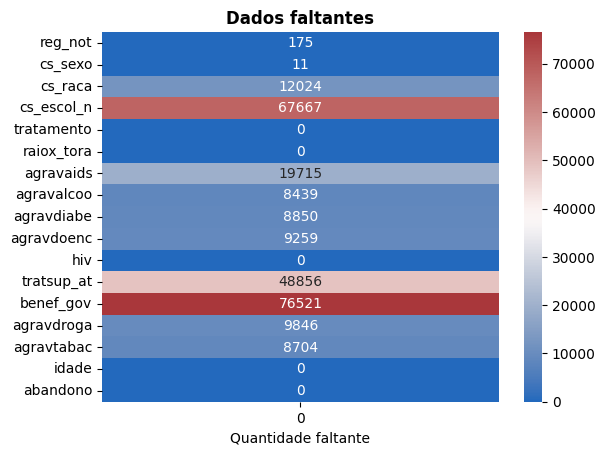

In [3]:
# plt.title('Dados faltantes',fontweight='bold')
# ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='vlag')
# ax.set_xlabel('Quantidade faltante')
# plt.show()

Nossa base de dados possui uma grande quantidade de dados faltantes, portanto vamos utilizar o método da imputação iterativa com um classificador de árvore de decisão para preencher os dados, sabendo que os dados nulos são todos categóricos.

In [ ]:
# Imputador iterativo com um classificador de árvore de decisão
# iterative_imputer = IterativeImputer(estimator=DecisionTreeClassifier(), random_state=42)
# df_imputed = pd.DataFrame(iterative_imputer.fit_transform(df), columns=df.columns)

Vamos salvar o dataframe imputado para não precisar rodar o imputador novamente. Usaremos ele para analisar os dados e para treinar o modelo.

In [ ]:
# df_imputed.to_csv("data/tuberculose_imputed.csv", index=False)

In [4]:
df = pd.read_csv('data/tuberculose_imputed.csv')
# Otimização de memória
for column in df.columns:
    df[column] = df[column].astype(np.int8)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243726 entries, 0 to 243725
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   reg_not     243726 non-null  int8 
 1   cs_sexo     243726 non-null  int8 
 2   cs_raca     243726 non-null  int8 
 3   cs_escol_n  243726 non-null  int8 
 4   tratamento  243726 non-null  int8 
 5   raiox_tora  243726 non-null  int8 
 6   agravaids   243726 non-null  int8 
 7   agravalcoo  243726 non-null  int8 
 8   agravdiabe  243726 non-null  int8 
 9   agravdoenc  243726 non-null  int8 
 10  hiv         243726 non-null  int8 
 11  tratsup_at  243726 non-null  int8 
 12  benef_gov   243726 non-null  int8 
 13  agravdroga  243726 non-null  int8 
 14  agravtabac  243726 non-null  int8 
 15  idade       243726 non-null  int8 
 16  abandono    243726 non-null  int8 
dtypes: int8(17)
memory usage: 4.0 MB


## Exploração dos dados

Inicialmente, vamos analisar a proporção de casos de abandono e não-abandono do dataset.

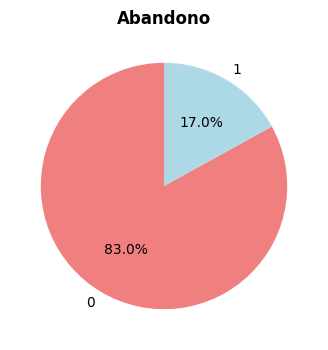

In [8]:
counts = df['abandono'].value_counts()

# Plotar o gráfico de pizza
plt.figure(figsize=(4, 4))
plt.pie(counts, labels=['0', '1'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.title('Abandono', fontweight='bold')
plt.show()

Percebemos que o dataset é muito desbalanceado, sendo 17% dos casos com desfecho de abandono. Geralmente, modelos de Machine Learning não desempenham bem em casos assim, portanto trataremos disso quando formos treinar os modelos. 

### Análise bivariada

Vamos analisar a relação do abandono com cada variável.

- #### Idade & Abandono

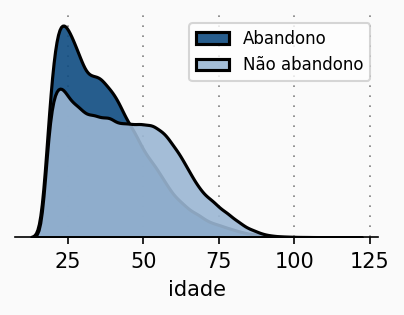

In [6]:
conts = ['idade']
background_color = "#fafafa"

fig = plt.figure(figsize=(10, 10), dpi=150,facecolor=background_color)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)


plot = 0
locals()["ax"+str(plot)] = fig.add_subplot(gs[0, 0])
locals()["ax"+str(plot)].set_facecolor(background_color)
locals()["ax"+str(plot)].tick_params(axis='y', left=False)
locals()["ax"+str(plot)].get_yaxis().set_visible(False)
for s in ["top","right","left"]:
    locals()["ax"+str(plot)].spines[s].set_visible(False)

a = df[df['abandono'] == 1]
na = df[df['abandono'] == 0]

sns.kdeplot(a['idade'], ax=locals()["ax"+str(plot)], color='#0f4c81', fill=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
sns.kdeplot(na['idade'],ax=locals()["ax"+str(plot)], color='#9bb7d4', fill=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
plt.legend(['Abandono', 'Não abandono'], loc='upper right', fontsize=8)

plt.show()

Comparando a idade dos grupos de pessoas que abandonaram o tratamento com as que não abandonaram, percecbe-se uma tendência maior das pessoas do primeiro grupo a serem mais jovens.

- #### Sexo & Abandono

In [ ]:
fig = px.histogram(df, x="cs_sexo", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Feminino", "Masculino"]
fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)

fig.show()

Nota-se que quase o dobro dos casos de tuberculose ocorre em homens e, percentualmente, há uma chance menor de abandono por mulheres.  
13% dos pacientes do sexo feminino abandonaram o tratamento, enquanto 19% do sexo masculino abandonaram. 

- #### Região de notificação & Abandono

In [ ]:
fig = px.histogram(df, x="reg_not", color="abandono",width=400, height=400)
# Definir os valores e os rótulos desejados
tickvals = [0, 1, 2, 3, 4]
ticktext = ["Norte", "Nordeste", "Sul", "Sudeste", "Centro-Oeste"]

# Atualiza os eixos x
fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Na região Norte, 17% dos casos notificados resultaram em abandono;
No Nordeste, também 17%;
No Sul, 19%;
No Sudeste, 16%;
No Centro-Oeste, 19%.  
Conclui-se que não há grande diferença na proporção de abandono entre as diferentes regiões.


- #### Raça & Abandono

In [ ]:
fig = px.histogram(df, x="cs_raca", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Branco", "Preto, Pardo, Amarelo, Indígena"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

13% das pessoas brancas com tuberculose abandonaram. Das pessoas de raça preta, parda, amarela ou indígena, 18,6% abandonaram. 

- #### Nível de escolaridade & Abandono

In [ ]:
fig = px.histogram(df, x="cs_escol_n", color="abandono",width=400, height=400)

tickvals = [0, 1, 2, 3]
ticktext = ["5- anos", "5-8 anos", "9-11 anos", "12+ anos"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Das pessoas com menos de 5 anos de escolaridade, 16,4% abandonaram o tratamento;  
Com 5 a 8 anos de escolaridade, 21,7%;  
Com 9 a 11 anos, 14,9%;  
Com mais de 12 anos, 7,8%;  
Percebe-se uma discrepância considerável da proporção de abandono entre as categorias. 

- #### Tipo de entrada do paciente na unidade de saúde & Abandono

In [ ]:
fig = px.histogram(df, x="tratamento", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Caso novo", "Retratamento"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Dentre os casos de pessoas sendo tratadas pela 1ª vez, 13,4% resultaram em abandono. Já dentre as pessoas em retratamento (podendo ser recidiva após cura ou reingresso após abandono), 38% abandonaram.  
Para essa variável em específico nota-se uma grande diferença entre os dois possíveis casos.

- #### Resultado da radiografia do tórax & Abandono

In [ ]:
fig = px.histogram(df, x="raiox_tora", color="abandono",width=400, height=400)

tickvals = [0, 1, 2]
ticktext = ["Normal", "Suspeito", "Não realizado"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Dos pacientes com resultado normal da radiografia do tórax, 13,2% abandonaram;  
Com resultado suspeito (77,3% dos casos), 16% abandonaram;
Dos que não realizaram, 21% abandonaram.
Observa-se uma tendência maior de abandono em caso de não-realização do raio-x.

- #### Agravo da AIDS associado à tuberculose & Abandono

In [ ]:
fig = px.histogram(df, x="agravaids", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que não houve agravo da AIDS associado à tuberculose por ocasião da notificação, 15,9% abandonaram, enquanto 31,7% abandonaram no caso de haver agravo, ou seja, praticamente o dobro.

- #### Agravo do Alcoolismo associado à tuberculose & Abandono


In [ ]:
fig = px.histogram(df, x="agravalcoo", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que não houve agravo do alcoolismo associado à tuberculose por ocasião da notificação, 14,6% abandonaram, enquanto 27% abandonaram no caso de haver agravo, ou seja, também é quase o dobro.

- #### Agravo da Diabetes associado à tuberculose & Abandono


In [ ]:
fig = px.histogram(df, x="agravdiabe", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que não houve agravo da diabetes associado à tuberculose por ocasião da notificação, 17,8% abandonaram, enquanto 9,8% abandonaram no caso de haver agravo. Nesse caso, ao contrário dos dois últimos analisados, o agravo da diabetes resulta em uma chance quase 2x menor de abandono do tratamento da tuberculose. 

- #### Agravo de Doenças Mentais associado à tuberculose & Abandono


In [ ]:
fig = px.histogram(df, x="agravdoenc", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que não houve agravo de doenças mentais associado à tuberculose por ocasião da notificação, 16,9% abandonaram, enquanto 19,6% abandonaram no caso de haver agravo. Nesse caso não há uma diferença notável.

- #### Agravo do Uso de drogas ilícitas associado à tuberculose & Abandono

In [ ]:
fig = px.histogram(df, x="agravdroga", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que não houve agravo do uso de drogas ilícitas associado à tuberculose por ocasião da notificação, 13,6% abandonaram, enquanto 39,2% abandonaram no caso de haver agravo, ou seja, praticamente o triplo, sendo essa uma diferença bastante relevante.

- #### Agravo do Tabagismo associado à tuberculose & Abandono

In [ ]:
fig = px.histogram(df, x="agravtabac", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que não houve agravo do tabagismo associado à tuberculose por ocasião da notificação, 14,3% abandonaram, enquanto 24,9% abandonaram no caso de haver agravo, ou seja, uma chance de 1,75x maior.

- #### HIV & Abandono

In [ ]:
fig = px.histogram(df, x="hiv", color="abandono",width=400, height=400)

tickvals = [0, 1, 2]
ticktext = ["Negativo", "Positivo", "Não realizado"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Nos casos em que os pacientes não realizaram o teste para o HIV, 23,9% abandonaram o tratamento da tuberculose, enquanto 14,4% abandonaram em caso de resultado negativo e 31% abandonaram em caso de resultado positivo ao teste, ou seja, há uma chance consideravelmente maior para esse último caso.

- #### Tratamento Diretamente Observado (TDO) & Abandono

In [ ]:
fig = px.histogram(df, x="tratsup_at", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

Dentre as pessoas com tuberculose que não receberam TDO, 22,6% abandonaram o tratamento, enquanto 10,4% das que receberam abandonaram. Nota-se que ao haver TDO, a chance do abandono é praticamente 2x menor.

- #### Beneficiário de programa de transferência de renda do governo & Abandono

In [ ]:
fig = px.histogram(df, x="benef_gov", color="abandono",width=400, height=400)

tickvals = [0, 1]
ticktext = ["Não", "Sim"]

fig.update_xaxes(tickvals=tickvals, ticktext=ticktext)
fig.show()

17% dos pacientes que são beneficiários de programas de transferência abandonaram o tratamento, enquanto 16,5% dos que não são abandonaram, portanto não se verifica uma diferença relevante.

### Conclusão da análise

A partir da análise feita, conclui-se que dentre todas as features categóricas do dataset, as seguintes aparentam estar menos relacionadas a uma maior ou menor chance de abandono do tratamento: região de notificação, agravo de doenças mentais (agravdoenc) e beneficiário de programa de transferência de renda do governo (benef_gov). Já as mais relacionadas aparentam ser: tipo de entrada na unidade de saúde (tratamento), agravo do uso de drogas ilícitas (agravdrog) e TDO (tratsup_at).
Podemos analisar o grau de dependência entre as variáveis categóricas e a variável alvo (abandono) usando `mutual_info_score`.

In [7]:
from sklearn.metrics import mutual_info_score
def cat_mut_inf(series):
    return mutual_info_score(series, df['abandono']) 
df_categ = df.drop(['abandono', 'idade'], axis=1)
df_cat = df_categ.apply(cat_mut_inf) 
df_cat = df_cat.sort_values(ascending=False).to_frame(name='mutual_info_score') 
df_cat

,mutual_info_score
tratamento,0.022286
agravdroga,0.021751
tratsup_at,0.013449
hiv,0.008493
agravalcoo,0.007705
agravtabac,0.006967
cs_escol_n,0.005405
agravaids,0.004563
cs_sexo,0.003015
agravdiabe,0.002387


Verifica-se que os valores mostrados condizem com a análise feita.

A partir disso, os testes e treinamentos dos modelos foram feitos no jupyter `modelando.ipynb`.